# Analyse descriptives des données "Openfoodfacts"

In [1]:
# importation des librairies nécessaires

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import scipy.stats as stats
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_palette("Set2")

In [3]:
filepath = 'openfoodfacts_clean_mean.csv'

In [4]:
df = pd.read_csv(filepath)
df.head(3)

,code,url,creator,product_name,quantity,brands,categories,countries,ingredients_text,serving_size,...,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,created_date,created_years,last_modified_date,last_modified_years
0,00000000000000225,http://world-en.openfoodfacts.org/product/0000...,Nutrinet-sante,Jeunes pousses,NaN,Endives,NaN,France,NaN,NaN,...,25.340919,8.278302,2.095412,7.60964,0.783117,0.313246,2021-06-16,2021,2021-06-16,2021
1,0000000000017,http://world-en.openfoodfacts.org/product/0000...,Kiliweb,Vitória crackers,NaN,NaN,NaN,France,NaN,NaN,...,70.100000,15.000000,2.095412,7.80000,1.400000,0.560000,2018-06-15,2018,2019-06-25,2019
2,000000000003327986,http://world-en.openfoodfacts.org/product/0000...,Kiliweb,Filetes de pollo empanado,NaN,NaN,NaN,other,NaN,NaN,...,25.340919,8.278302,2.095412,7.60964,0.783117,0.313246,2019-11-19,2019,2019-11-19,2019


In [5]:
df.columns

Index(['code', 'url', 'creator', 'product_name', 'quantity', 'brands',
       'categories', 'countries', 'ingredients_text', 'serving_size',
       'serving_quantity', 'additives_n', 'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutriscore_score',
       'nutriscore_grade', 'nova_group', 'pnns_groups_1', 'pnns_groups_2',
       'states', 'main_category', 'image_url', 'image_ingredients_url',
       'image_nutrition_url', 'energy-kcal_100g', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g', 'created_date',
       'created_years', 'last_modified_date', 'last_modified_years'],
      dtype='object')

In [6]:
col_drop = ['code', 'url', 'creator', 'quantity', 'categories', 'ingredients_text', 'serving_quantity', 'serving_size', 'states',
            'main_category', 'image_url', 'image_ingredients_url', 'image_nutrition_url'] 

df.drop(col_drop, axis=1, inplace=True)

In [7]:
col_cat = ["additives_n", "countries", "ingredients_from_palm_oil_n", "ingredients_that_may_be_from_palm_oil_n",
           "nutriscore_score", "nutriscore_grade", "nova_group"]

for col in col_cat:
    df[col] = df[col].astype("category")

In [8]:
df.shape

(1226839, 25)

# Analyses univariées

## Description des variables qualitatives

In [9]:
print('Nombre de produits :', len(df['product_name'].unique()))
print("Produit le plus représenté :", df['product_name'].mode()[0])

Nombre de produits : 723760
Produit le plus représenté : unknown


In [10]:
df['count'] = 1
count = df.groupby("product_name").sum().sort_values(by='count', ascending=False).head(10)
count = count['count'].reset_index()
count = count[1:]

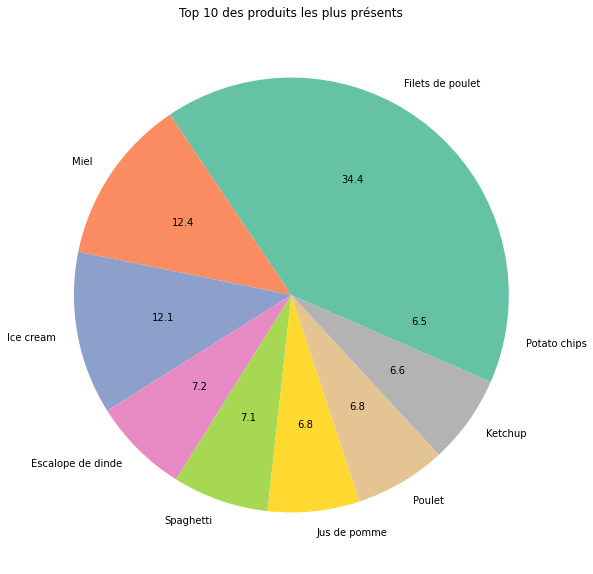

In [11]:
plt.figure(figsize=(10,10))
plt.pie(x=count["count"], autopct='%.1f', labels=count["product_name"])
plt.title("Top 10 des produits les plus présents")
plt.show()

In [12]:
print('Nombre de marques :', len(df['brands'].unique()))
print("Marque la plus représentée :", df['brands'].mode()[0])

Nombre de marques : 96965
Marque la plus représentée : Carrefour


In [13]:
count = df.groupby("brands").sum().sort_values(by='count', ascending=False).head(10)
count = count['count'].reset_index()

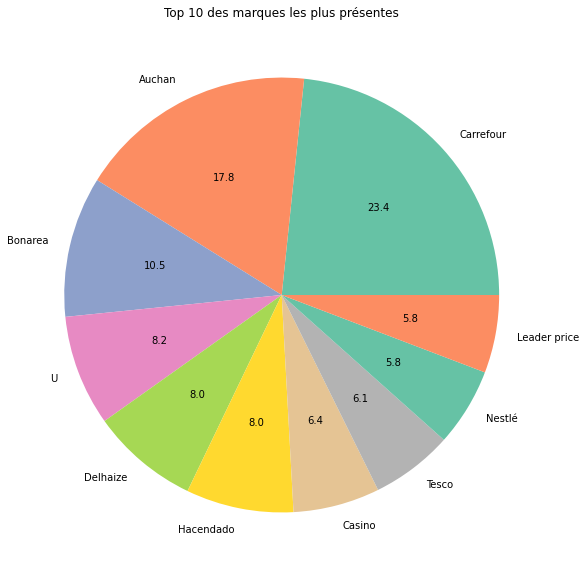

In [14]:
plt.figure(figsize=(10,10))
plt.pie(x=count["count"], autopct='%.1f', labels=count["brands"])
plt.title("Top 10 des marques les plus présentes")
plt.show()

In [15]:
print('Nombre de pays :', len(df['countries'].unique()))
print("Pays le plus représenté :", df['countries'].mode()[0])

Nombre de pays : 2
Pays le plus représenté : other


In [16]:
count = df.groupby("countries").sum().sort_values(by='count', ascending=False).head(10)
count = count['count'].reset_index()

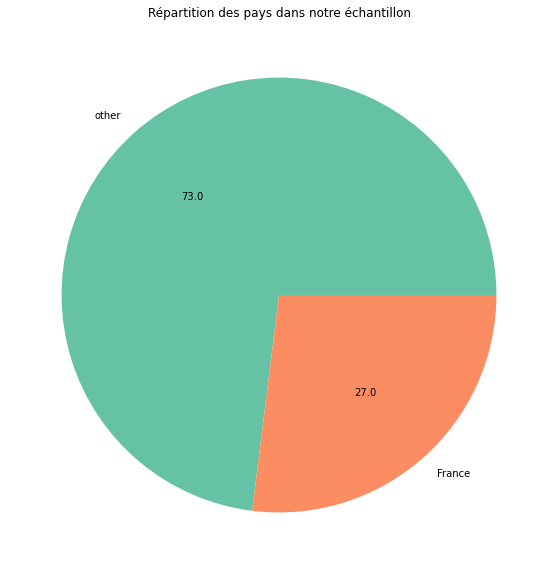

In [17]:
plt.figure(figsize=(10,10))
plt.pie(x=count["count"], autopct='%.1f', labels=count["countries"])
plt.title("Répartition des pays dans notre échantillon")
plt.show()

In [18]:
df.drop('count', axis=1, inplace=True)

In [19]:
print("Nombre d'années de création : ", len(df["created_years"].unique()))
print("Année avec le plus d'ajout de produits :", df['created_years'].mode()[0])

Nombre d'années de création :  7
Année avec le plus d'ajout de produits : 2020


In [20]:
print("Nombre d'années de modification : ", len(df['last_modified_years'].unique()))
print("Année avec le plus de mise à jour de produits :", df['last_modified_years'].mode()[0])

Nombre d'années de modification :  3
Année avec le plus de mise à jour de produits : 2020


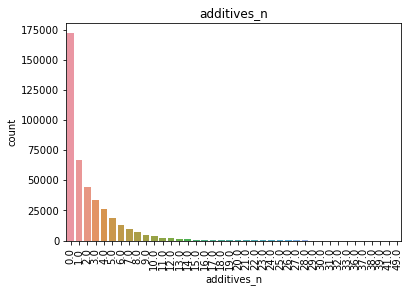

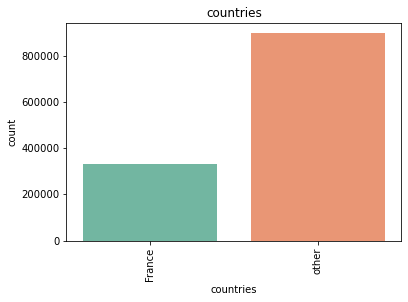

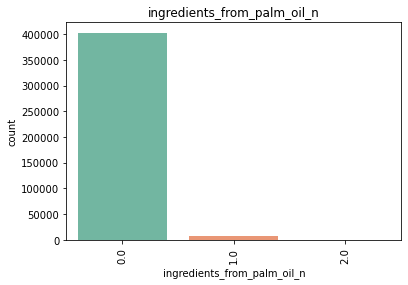

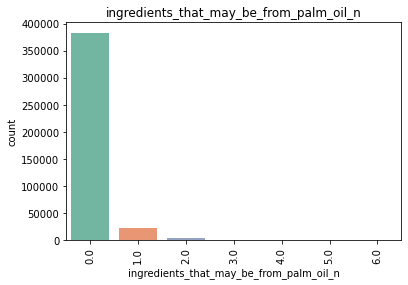

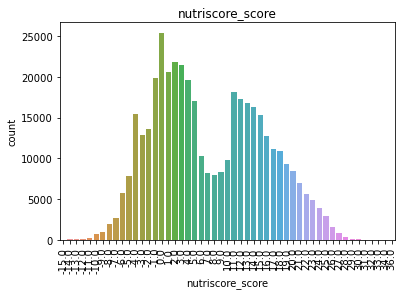

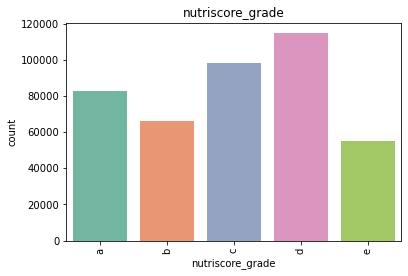

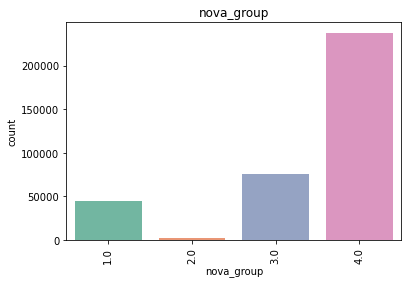

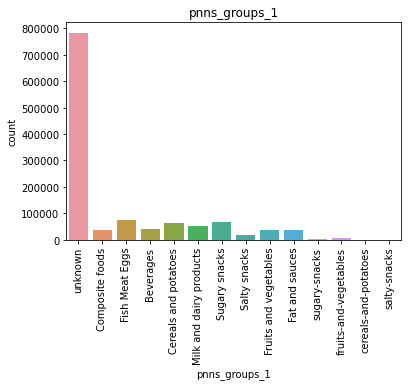

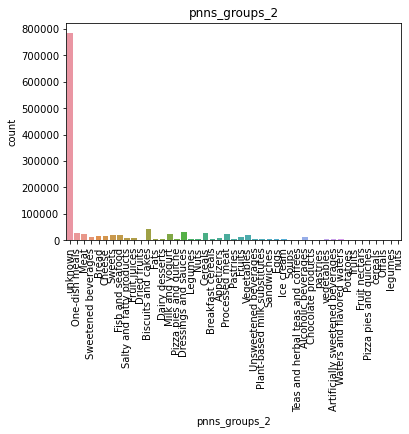

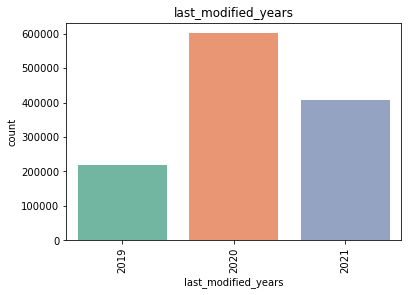

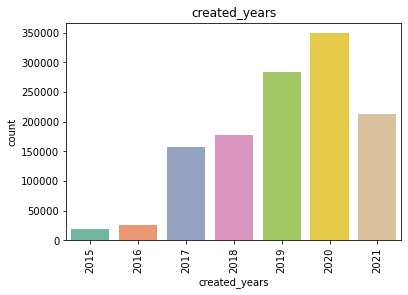

In [21]:
col_cat = ["additives_n", "countries", "ingredients_from_palm_oil_n", "ingredients_that_may_be_from_palm_oil_n",
           "nutriscore_score", "nutriscore_grade", "nova_group", "pnns_groups_1", "pnns_groups_2", "last_modified_years", "created_years"]

for col in col_cat:
    sns.countplot(x=col, data=df)
    plt.xticks(rotation=90)
    plt.title(col)
    plt.show()

## Description de la distribution des variables quantitatives

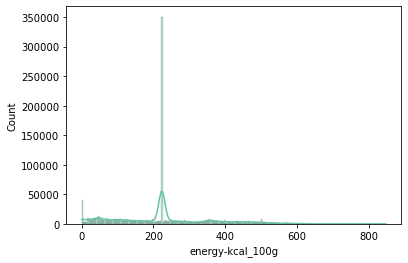

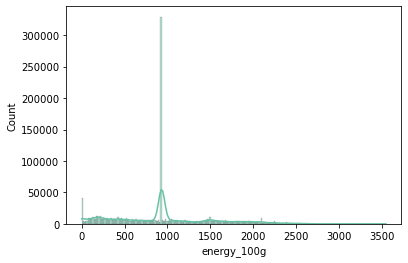

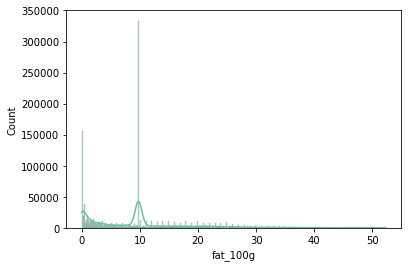

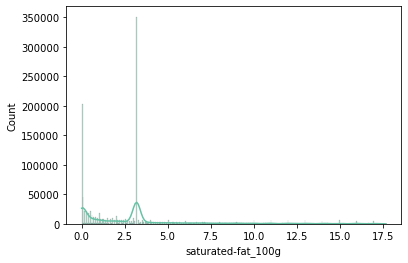

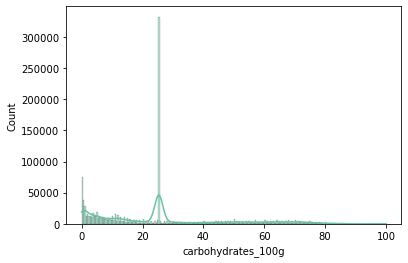

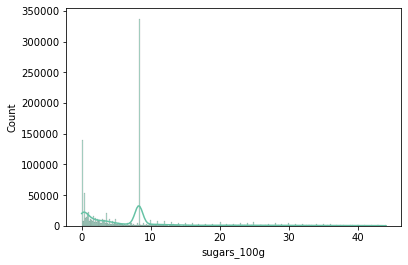

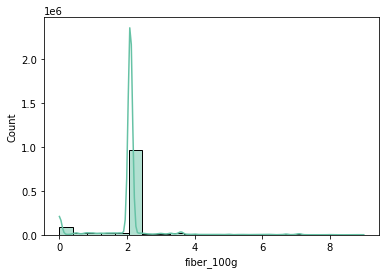

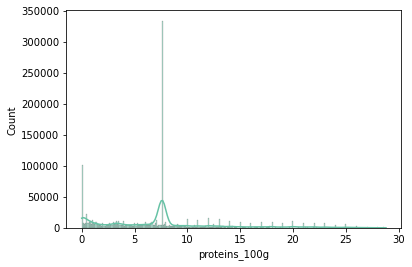

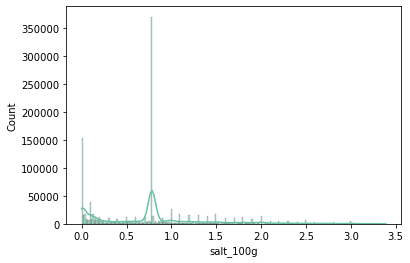

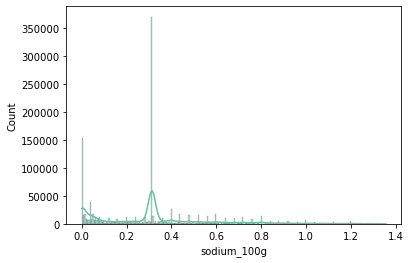

In [22]:
for var in df.columns:
    if df[var].dtypes == 'float64':
        sns.histplot(x=var, data=df, kde=True)
        plt.show()

In [23]:
pg.normality(df, method='normaltest', alpha=0.05)

,W,pval,normal
energy-kcal_100g,62162.599628,0.0,False
energy_100g,61105.547141,0.0,False
fat_100g,359978.179679,0.0,False
saturated-fat_100g,428728.266419,0.0,False
carbohydrates_100g,136489.199885,0.0,False
sugars_100g,415893.683337,0.0,False
fiber_100g,654172.488534,0.0,False
proteins_100g,181657.046571,0.0,False
salt_100g,219488.442333,0.0,False
sodium_100g,219497.490460,0.0,False


In [24]:
pg.homoscedasticity(df, method='levene', alpha=0.05)

,W,pval,equal_var
levene,0.072491,1.0,True


Levene plus efficace que Bartlett car Bartlett dans cas de distribution normale


## Analyses descriptives des variables

### Analyses graphiques des variables

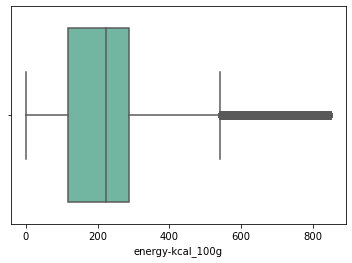

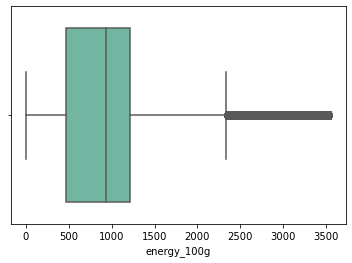

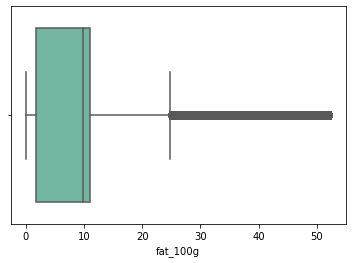

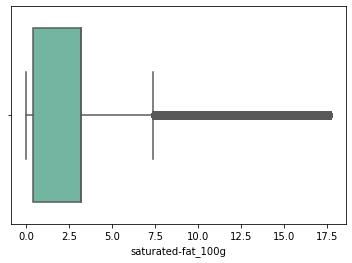

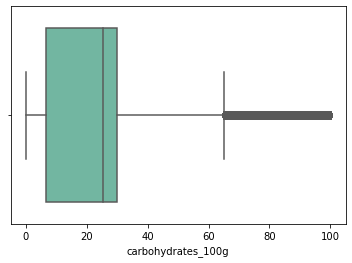

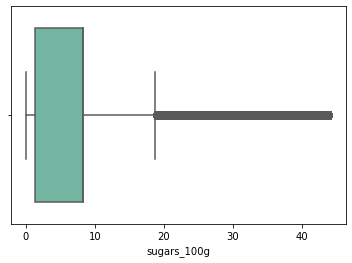

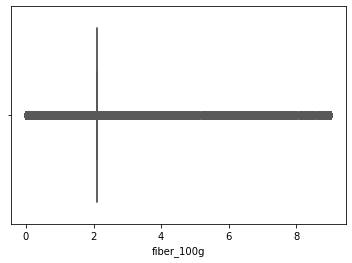

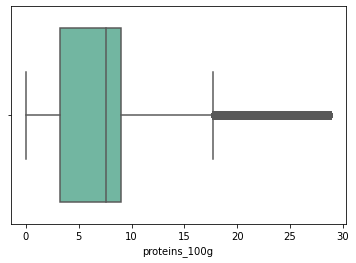

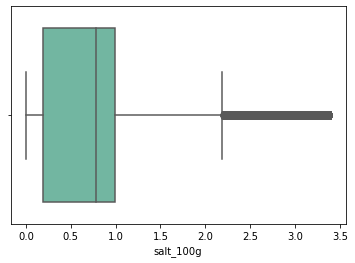

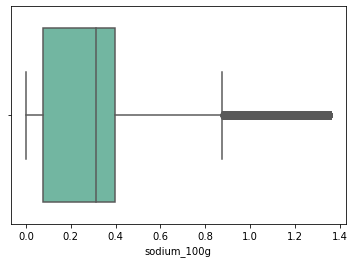

In [25]:
for var in df.columns:
    if df[var].dtypes == 'float64':
        sns.boxplot(x=var, data=df)
        plt.show()

### Analyses statistiques des variables

In [26]:
df.describe()

,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,created_years,last_modified_years
count,1.226839e+06,1.226839e+06,1.226839e+06,1.226839e+06,1.226839e+06,1.226839e+06,1.226839e+06,1.226839e+06,1.226839e+06,1.226839e+06,1.226839e+06,1.226839e+06
mean,2.233780e+02,9.322027e+02,9.764784e+00,3.192640e+00,2.534092e+01,8.278302e+00,2.095412e+00,7.609640e+00,7.831166e-01,3.132459e-01,2.019104e+03,2.020156e+03
std,1.402767e+02,5.930190e+02,9.570967e+00,3.565255e+00,2.181557e+01,9.274117e+00,1.059043e+00,5.945245e+00,6.609528e-01,2.643819e-01,1.441123e+00,6.972212e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.015000e+03,2.019000e+03
25%,1.158690e+02,4.660000e+02,1.800000e+00,4.000000e-01,6.700000e+00,1.360000e+00,2.095412e+00,3.200000e+00,1.900000e-01,7.600000e-02,2.018000e+03,2.020000e+03
50%,2.233780e+02,9.322027e+02,9.764784e+00,3.192640e+00,2.534092e+01,8.278302e+00,2.095412e+00,7.609640e+00,7.831166e-01,3.132459e-01,2.019000e+03,2.020000e+03
75%,2.860000e+02,1.213000e+03,1.100000e+01,3.192640e+00,3.000000e+01,8.278302e+00,2.095412e+00,9.000000e+00,9.900000e-01,3.960000e-01,2.020000e+03,2.021000e+03
max,8.480000e+02,3.548000e+03,5.233333e+01,1.770000e+01,1.000000e+02,4.410000e+01,9.000000e+00,2.880000e+01,3.392857e+00,1.357143e+00,2.021000e+03,2.021000e+03


# Hypothèses de travail

Notre jeu de données est composée de différentes variables : 
- Des variables en lien avec l'identification des produits (noms, endroits où ils sont commercialisés, date d'ajout dans la base, date de modification dans la base)
- Des variables qui mesurent la qualité des produits (nutriscore, groupe NOVA)
- Des variables sur les différentes valeurs nutrionnelles du produit (graisse, graisse saturée, carbohydrates, sucres, fibres, protéines, sel)
- Des variables sur l'énergie que l'on trouve dans chaque produit (énergie en kcal)

On peut donc se demander si les différents scores sur la qualité des produits ne vont pas permettre d'avoir une idée sur la valeur nutrionnelle des aliments. Par exemple, un aliment avec un nutriscore A ou appartenant au groupe NOVA 1 contient peu de graisses, peu de sucre, peu de sel et peu de carbohydrates. On peut aussi se demander dans quel mesure ces nutriments vont avoir un impact sur le calcul du nutriscore.
On peut aussi se demander si la quantité d'ingrédients en lien avec l'huile de palme va avoir un impact sur le nutriscore et donc la composition des aliments. 

# Analyses bivariées des variables

## Analyses bivariées des variables quantitatives

### Corrélation entre les variables quantitatives

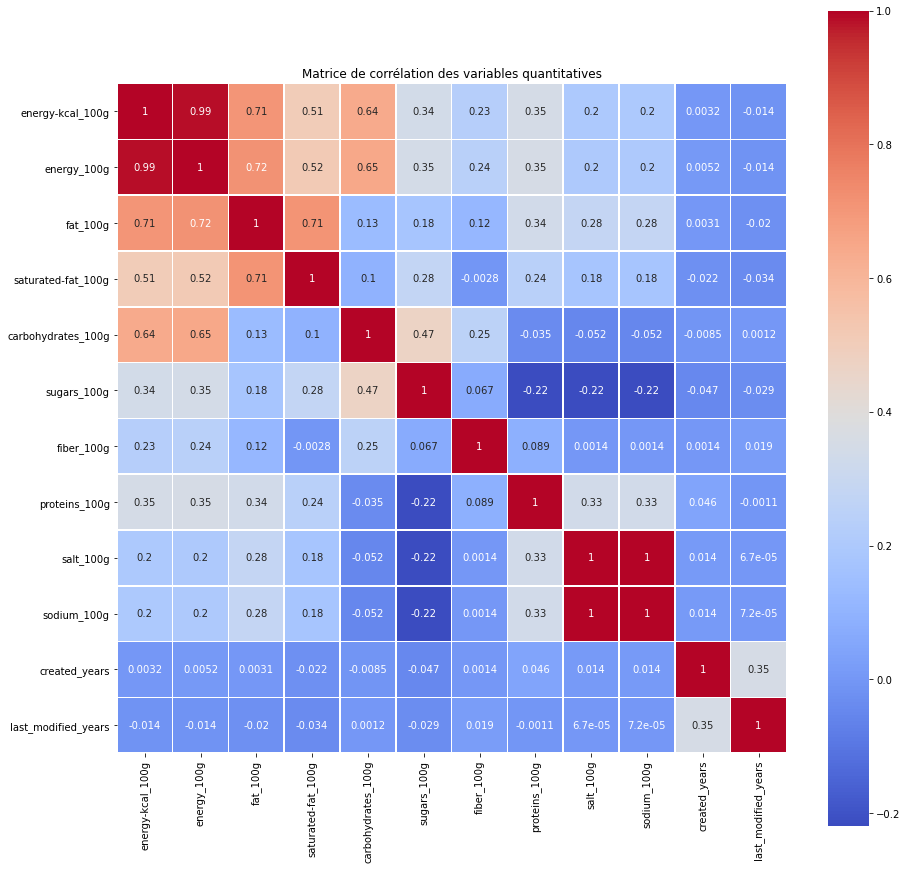

In [27]:
corr_matrix = df.corr()

plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix, cmap="coolwarm", linewidths=.5, annot=True, cbar=True, square=True)
plt.title("Matrice de corrélation des variables quantitatives")
plt.show()

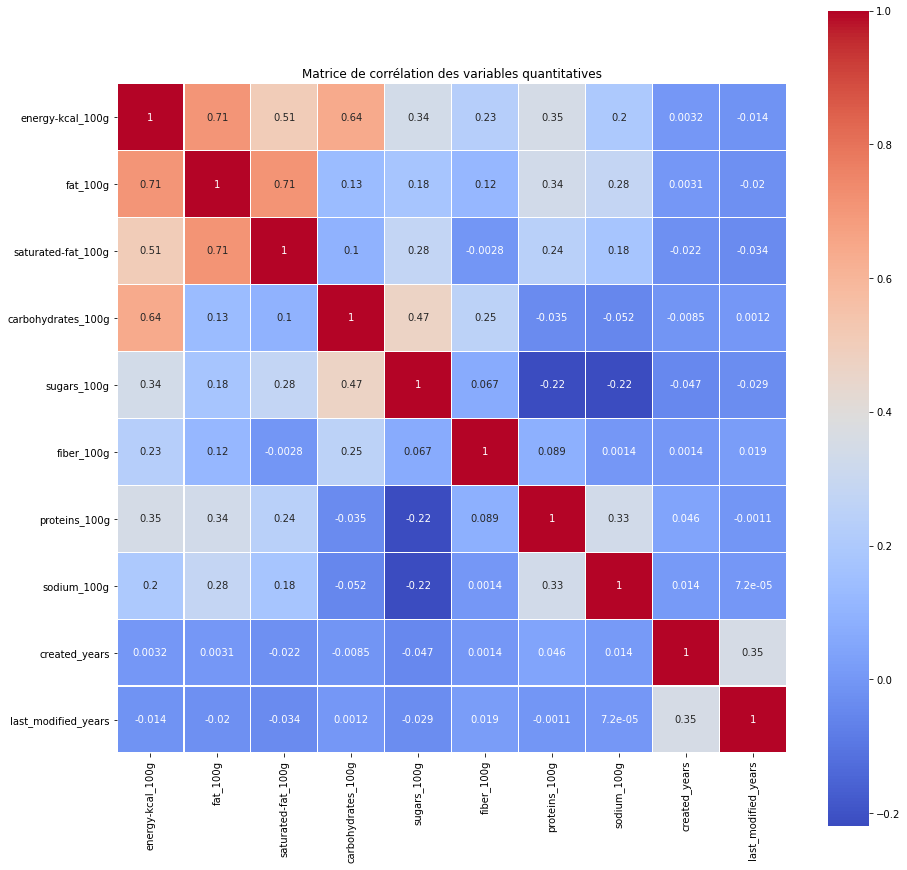

In [28]:
df.drop(['energy_100g', 'salt_100g'], axis=1, inplace=True)

corr_matrix = df.corr()

plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix, cmap="coolwarm", linewidths=.5, annot=True, cbar=True, square=True)
plt.title("Matrice de corrélation des variables quantitatives")
plt.show()

La matrice de corrélation permet de voir les corrélations qui existent entre les différentes variables quantitatives. On ne va donc pas s'intéresser aux variables qualitatives comme les différents scores que l'on a pu voir plus haut. 
On remarque une forte corrélation positive entre la **quantité d'énergie en kcal pour 100g** et la **quantité de graisses pour 100g** *(0.71)*, la **quantité de graisses saturées pour 100g** *(0.51)* et la **quantité de carbohydrates pour 100g** *(0.64)*. De plus, on remarque une forte corrélation positive entre la **quantité de graisses pour 100g** et la **quantité de graisses saturées pour 100g** *(0.71)*. Enfin, on observe une dernière corrélation positive moyenne entre la **quantité de sucres pour 100g** et la **quantité de carbohydrates pour 100g** *(0.47)*. 

On va donc réaliser une régression linéaire en partant de ces corrélations pour mieux voir ce qui unit ces variables

### Analyse de régression entre variables quantitatives

- Energie en Kcal et quantité de graisses pour 100g

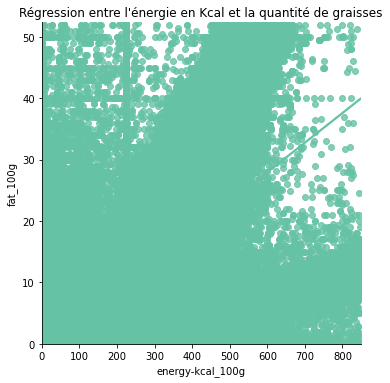

In [29]:
sns.lmplot(x="energy-kcal_100g", y="fat_100g", data=df)
plt.title("Régression entre l'énergie en Kcal et la quantité de graisses")
plt.xlim(df["energy-kcal_100g"].min(), df["energy-kcal_100g"].max())
plt.ylim(df["fat_100g"].min(), df["fat_100g"].max())
plt.show()

In [30]:
pg.linear_regression(X=df["energy-kcal_100g"], y=df["fat_100g"], add_intercept=True, alpha=0.05)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-1.016800,0.011484,-88.53862,0.0,0.50043,0.50043,-1.039308,-0.994291
1,energy-kcal_100g,0.048266,0.000044,1108.57976,0.0,0.50043,0.50043,0.048181,0.048351


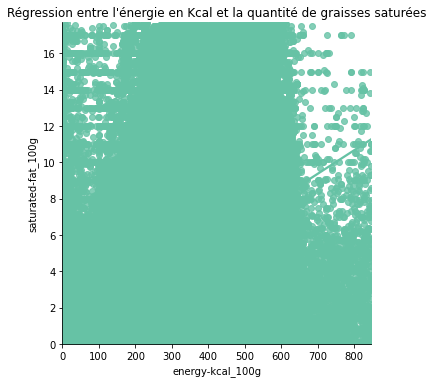

In [31]:
sns.lmplot(x="energy-kcal_100g", y="saturated-fat_100g", data=df)
plt.title("Régression entre l'énergie en Kcal et la quantité de graisses saturées")
plt.xlim(df["energy-kcal_100g"].min(), df["energy-kcal_100g"].max())
plt.ylim(df["saturated-fat_100g"].min(), df["saturated-fat_100g"].max())
plt.show()

In [32]:
pg.linear_regression(X=df["energy-kcal_100g"], y=df["saturated-fat_100g"], add_intercept=True, alpha=0.05)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.301025,0.005209,57.793056,0.0,0.259412,0.259411,0.290817,0.311234
1,energy-kcal_100g,0.012945,0.000020,655.540783,0.0,0.259412,0.259411,0.012906,0.012984


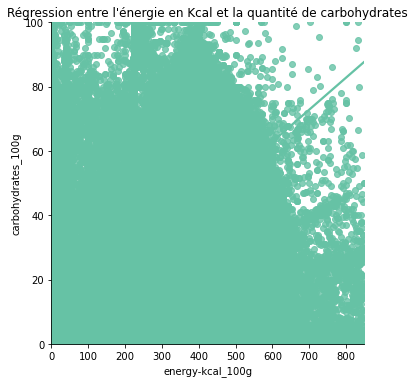

In [33]:
sns.lmplot(x="energy-kcal_100g", y="carbohydrates_100g", data=df)
plt.title("Régression entre l'énergie en Kcal et la quantité de carbohydrates")
plt.xlim(df["energy-kcal_100g"].min(), df["energy-kcal_100g"].max())
plt.ylim(df["carbohydrates_100g"].min(), df["carbohydrates_100g"].max())
plt.show()

In [34]:
pg.linear_regression(X=df["energy-kcal_100g"], y=df["carbohydrates_100g"], add_intercept=True, alpha=0.05)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,3.067538,0.028421,107.931291,0.0,0.411082,0.411082,3.011833,3.123242
1,energy-kcal_100g,0.099712,0.000108,925.402412,0.0,0.411082,0.411082,0.099500,0.099923


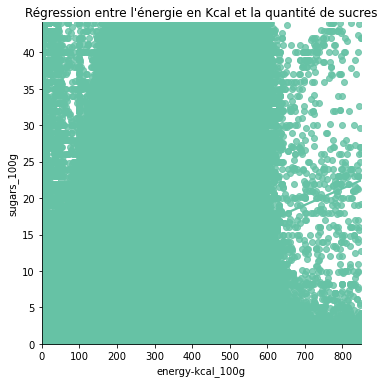

In [35]:
sns.lmplot(x="energy-kcal_100g", y="sugars_100g", data=df)
plt.title("Régression entre l'énergie en Kcal et la quantité de sucres")
plt.xlim(df["energy-kcal_100g"].min(), df["energy-kcal_100g"].max())
plt.ylim(df["sugars_100g"].min(), df["sugars_100g"].max())
plt.show()

In [36]:
pg.linear_regression(X=df["energy-kcal_100g"], y=df["sugars_100g"], add_intercept=True, alpha=0.05)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,3.223437,0.014793,217.899337,0.0,0.117156,0.117155,3.194442,3.252431
1,energy-kcal_100g,0.022629,0.000056,403.490517,0.0,0.117156,0.117155,0.022519,0.022739


- Graisses et graisses saturées

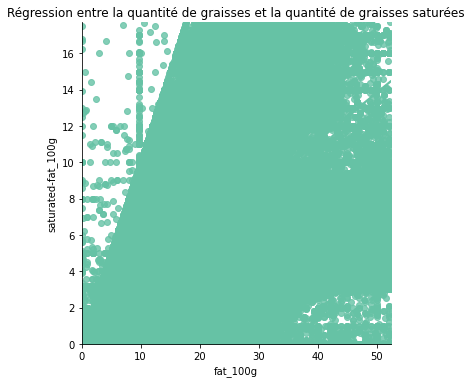

In [37]:
sns.lmplot(x="fat_100g", y="saturated-fat_100g", data=df)
plt.title("Régression entre la quantité de graisses et la quantité de graisses saturées")
plt.xlim(df["fat_100g"].min(), df["fat_100g"].max())
plt.ylim(df["saturated-fat_100g"].min(), df["saturated-fat_100g"].max())
plt.show()

In [38]:
pg.linear_regression(X=df["fat_100g"], y=df["saturated-fat_100g"], add_intercept=True, alpha=0.05)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.610167,0.003238,188.417839,0.0,0.504054,0.504053,0.603819,0.616514
1,fat_100g,0.264468,0.000237,1116.643487,0.0,0.504054,0.504053,0.264004,0.264932


- Carbohydrates et sucres

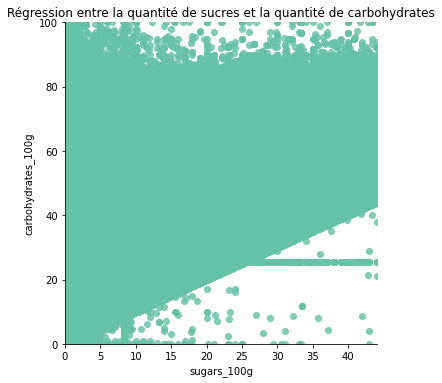

In [39]:
sns.lmplot(x="sugars_100g", y="carbohydrates_100g", data=df)
plt.title("Régression entre la quantité de sucres et la quantité de carbohydrates")
plt.xlim(df["sugars_100g"].min(), df["sugars_100g"].max())
plt.ylim(df["carbohydrates_100g"].min(), df["carbohydrates_100g"].max())
plt.show()

In [40]:
pg.linear_regression(X=df["sugars_100g"], y=df["carbohydrates_100g"], add_intercept=True, alpha=0.05)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,16.179433,0.023297,694.495181,0.0,0.221341,0.22134,16.133773,16.225094
1,sugars_100g,1.106687,0.001874,590.541308,0.0,0.221341,0.22134,1.103014,1.110360


## Analyses bivariées des variable qualitatives et quantitatives

### Analyse entre la quantité de graisse et les différentes variables qualitatives

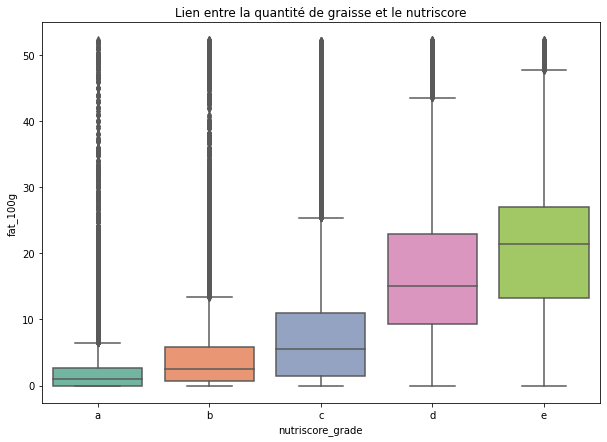

In [41]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="nutriscore_grade", y="fat_100g", data=df)
plt.title("Lien entre la quantité de graisse et le nutriscore")
plt.show()

In [42]:
pg.welch_anova(data=df, dv="fat_100g", between="nutriscore_grade")

,Source,ddof1,ddof2,F,p-unc,np2
0,nutriscore_grade,4,182385.942884,60352.28629,0.0,0.323175


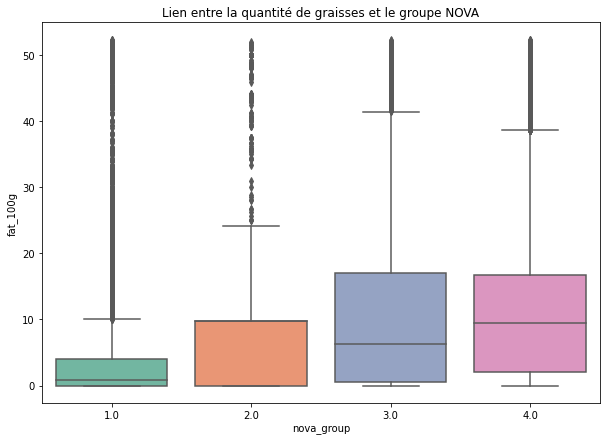

In [43]:
plt.figure(figsize=(10,7))
sns.boxplot(x="nova_group", y="fat_100g", data=df)
plt.title("Lien entre la quantité de graisses et le groupe NOVA")
plt.show()

In [44]:
pg.welch_anova(data=df, dv="fat_100g", between="nova_group")

,Source,ddof1,ddof2,F,p-unc,np2
0,nova_group,3,9551.774985,10998.518577,0.0,0.047531


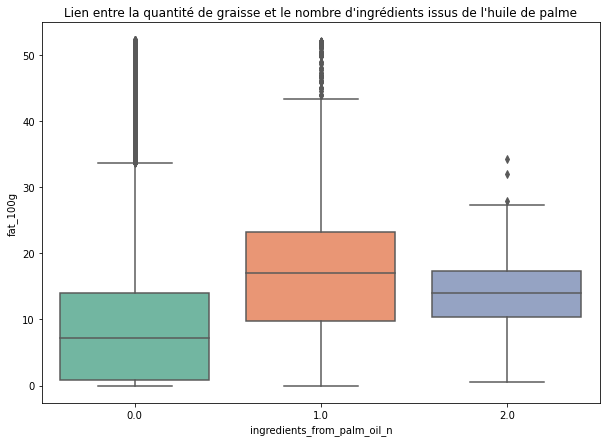

In [45]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="ingredients_from_palm_oil_n", y="fat_100g", data=df)
plt.title("Lien entre la quantité de graisse et le nombre d'ingrédients issus de l'huile de palme")
plt.show()

In [46]:
pg.welch_anova(data=df, dv="fat_100g", between="ingredients_from_palm_oil_n")

,Source,ddof1,ddof2,F,p-unc,np2
0,ingredients_from_palm_oil_n,2,284.170306,1914.373961,1.259035e-165,0.008574


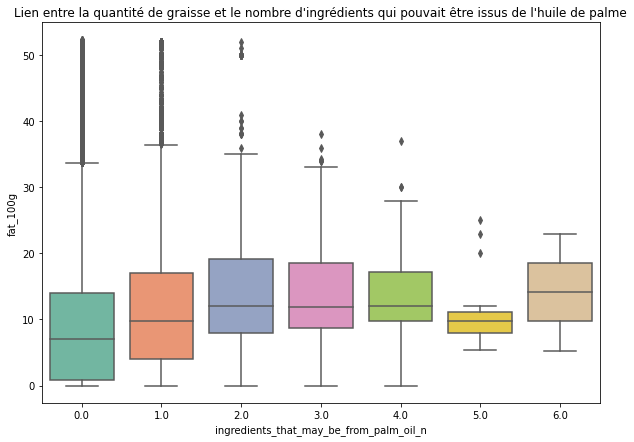

In [47]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="ingredients_that_may_be_from_palm_oil_n", y="fat_100g", data=df)
plt.title("Lien entre la quantité de graisse et le nombre d'ingrédients qui pouvait être issus de l'huile de palme")
plt.show()

In [48]:
pg.welch_anova(data=df, dv="fat_100g", between="ingredients_that_may_be_from_palm_oil_n")

,Source,ddof1,ddof2,F,p-unc,np2
0,ingredients_that_may_be_from_palm_oil_n,6,14.935418,278.921367,1.831992e-14,0.00389


### Analyse entre la quantité de sucre et les différentes variables qualitatives

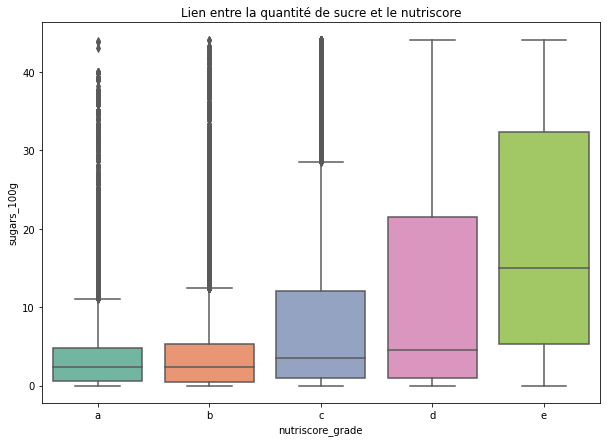

In [49]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="nutriscore_grade", y="sugars_100g", data=df)
plt.title("Lien entre la quantité de sucre et le nutriscore")
plt.show()

In [50]:
pg.welch_anova(data=df, dv="sugars_100g", between="nutriscore_grade")

,Source,ddof1,ddof2,F,p-unc,np2
0,nutriscore_grade,4,184268.245747,23930.824186,0.0,0.190725


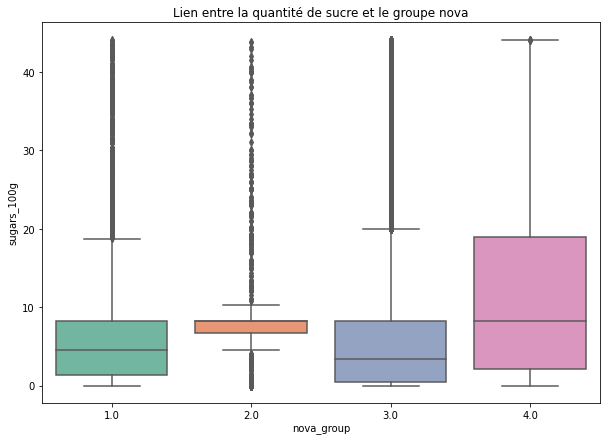

In [51]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="nova_group", y="sugars_100g", data=df)
plt.title("Lien entre la quantité de sucre et le groupe nova")
plt.show()

In [52]:
pg.welch_anova(data=df, dv="sugars_100g", between="nova_group")

,Source,ddof1,ddof2,F,p-unc,np2
0,nova_group,3,9769.949248,10397.321369,0.0,0.070938


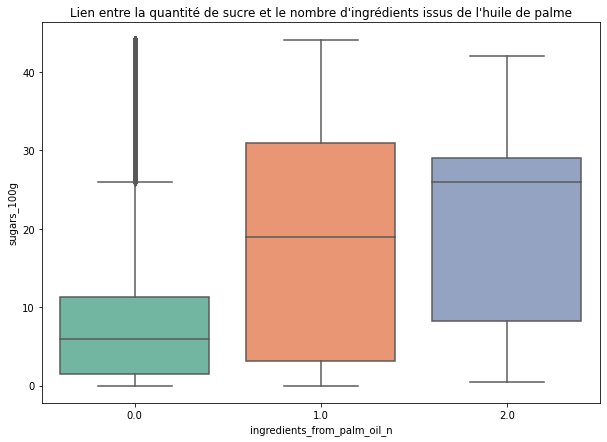

In [53]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="ingredients_from_palm_oil_n", y="sugars_100g", data=df)
plt.title("Lien entre la quantité de sucre et le nombre d'ingrédients issus de l'huile de palme")
plt.show()

In [54]:
pg.welch_anova(data=df, dv="sugars_100g", between="ingredients_from_palm_oil_n")

,Source,ddof1,ddof2,F,p-unc,np2
0,ingredients_from_palm_oil_n,2,283.841364,1419.181747,1.606312e-148,0.022313


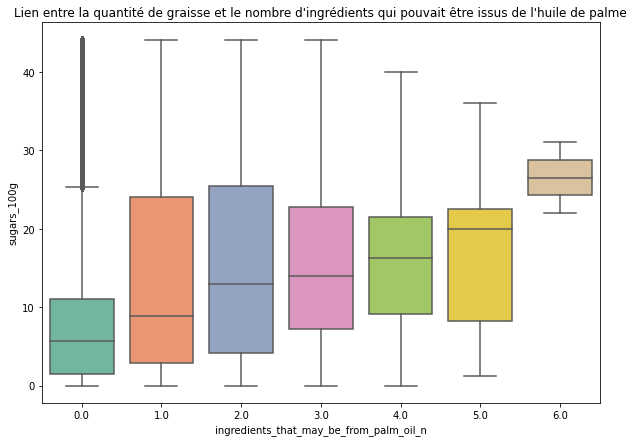

In [55]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="ingredients_that_may_be_from_palm_oil_n", y="sugars_100g", data=df)
plt.title("Lien entre la quantité de graisse et le nombre d'ingrédients qui pouvait être issus de l'huile de palme")
plt.show()

In [56]:
pg.welch_anova(data=df, dv="sugars_100g", between="ingredients_that_may_be_from_palm_oil_n")

,Source,ddof1,ddof2,F,p-unc,np2
0,ingredients_that_may_be_from_palm_oil_n,6,14.935332,656.512816,3.215471e-17,0.024883


### Analyse entre la quantité de protéines et les différentes variables qualitatives

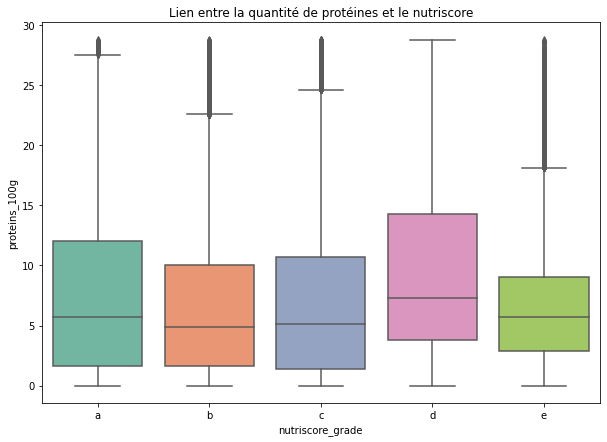

In [57]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="nutriscore_grade", y="proteins_100g", data=df)
plt.title("Lien entre la quantité de protéines et le nutriscore")
plt.show()

In [58]:
pg.welch_anova(data=df, dv="proteins_100g", between="nutriscore_grade")

,Source,ddof1,ddof2,F,p-unc,np2
0,nutriscore_grade,4,191017.071237,2392.042812,0.0,0.023197


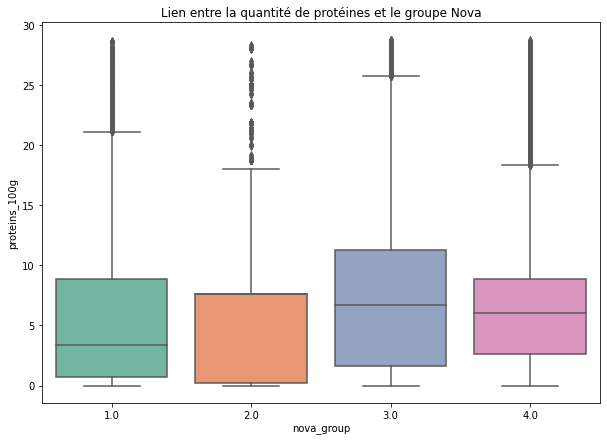

In [59]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="nova_group", y="proteins_100g", data=df)
plt.title("Lien entre la quantité de protéines et le groupe Nova")
plt.show()

In [60]:
pg.welch_anova(data=df, dv="proteins_100g", between="nova_group")

,Source,ddof1,ddof2,F,p-unc,np2
0,nova_group,3,9501.57954,980.980307,0.0,0.026887


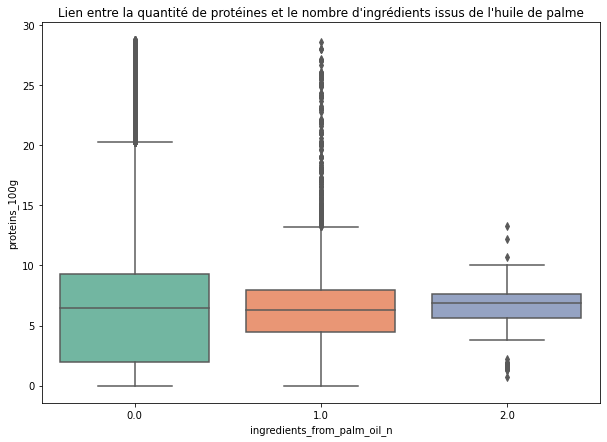

In [61]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="ingredients_from_palm_oil_n", y="proteins_100g", data=df)
plt.title("Lien entre la quantité de protéines et le nombre d'ingrédients issus de l'huile de palme")
plt.show()

In [62]:
pg.welch_anova(data=df, dv="proteins_100g", between="ingredients_from_palm_oil_n")

,Source,ddof1,ddof2,F,p-unc,np2
0,ingredients_from_palm_oil_n,2,284.884011,17.41338,7.331537e-08,0.013995


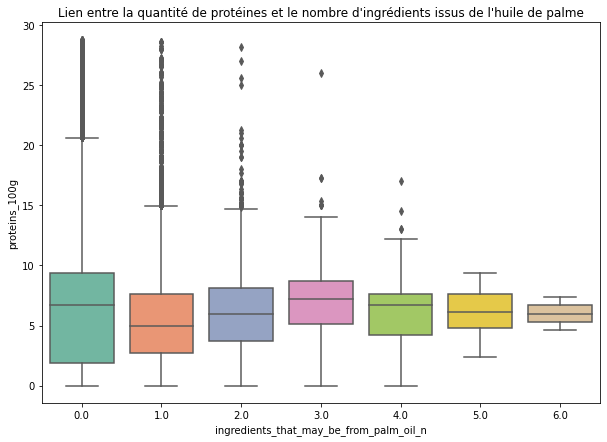

In [63]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="ingredients_that_may_be_from_palm_oil_n", y="proteins_100g", data=df)
plt.title("Lien entre la quantité de protéines et le nombre d'ingrédients issus de l'huile de palme")
plt.show()

In [64]:
pg.welch_anova(data=df, dv="proteins_100g", between="ingredients_that_may_be_from_palm_oil_n")

,Source,ddof1,ddof2,F,p-unc,np2
0,ingredients_that_may_be_from_palm_oil_n,6,14.937456,284.939209,1.559117e-14,0.01662


### Analyse entre la quantité de carbohydrates et les différentes variables quanlitatives

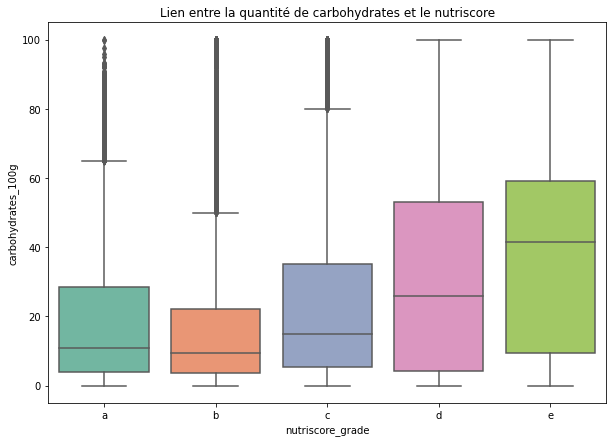

In [65]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="nutriscore_grade", y="carbohydrates_100g", data=df)
plt.title("Lien entre la quantité de carbohydrates et le nutriscore")
plt.show()

In [66]:
pg.welch_anova(data=df, dv="carbohydrates_100g", between="nutriscore_grade")

,Source,ddof1,ddof2,F,p-unc,np2
0,nutriscore_grade,4,187755.339853,5101.912828,0.0,0.046425


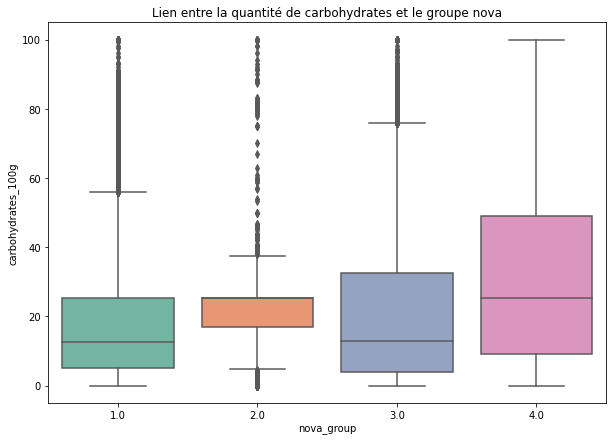

In [67]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="nova_group", y="carbohydrates_100g", data=df)
plt.title("Lien entre la quantité de carbohydrates et le groupe nova")
plt.show()

In [68]:
pg.welch_anova(data=df, dv="carbohydrates_100g", between="nova_group")

,Source,ddof1,ddof2,F,p-unc,np2
0,nova_group,3,9671.747303,1933.567212,0.0,0.022003


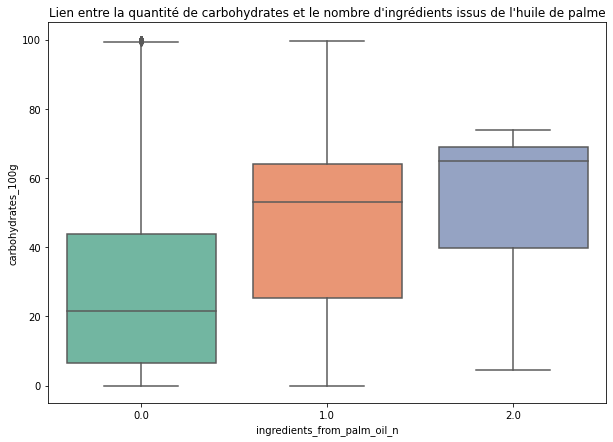

In [69]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="ingredients_from_palm_oil_n", y="carbohydrates_100g", data=df)
plt.title("Lien entre la quantité de carbohydrates et le nombre d'ingrédients issus de l'huile de palme")
plt.show()

In [70]:
pg.welch_anova(data=df, dv="carbohydrates_100g", between="ingredients_from_palm_oil_n")

,Source,ddof1,ddof2,F,p-unc,np2
0,ingredients_from_palm_oil_n,2,283.976014,2627.329235,6.580880e-184,0.015834


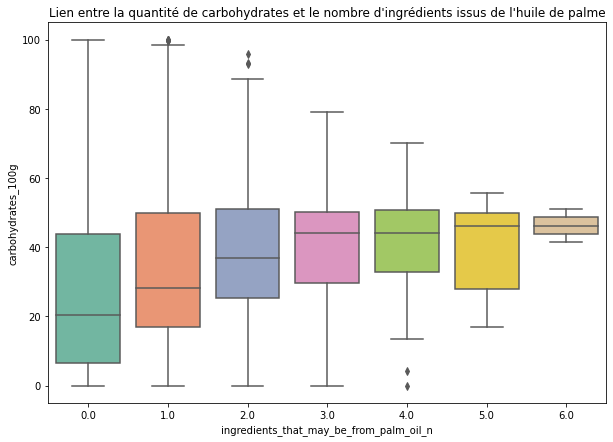

In [71]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="ingredients_that_may_be_from_palm_oil_n", y="carbohydrates_100g", data=df)
plt.title("Lien entre la quantité de carbohydrates et le nombre d'ingrédients issus de l'huile de palme")
plt.show()

In [72]:
pg.welch_anova(data=df, dv="carbohydrates_100g", between="ingredients_that_may_be_from_palm_oil_n")

,Source,ddof1,ddof2,F,p-unc,np2
0,ingredients_that_may_be_from_palm_oil_n,6,14.937257,546.214412,1.255913e-16,0.01067


### Analyse entre la quantité de sel et les différentes variables qualitatives

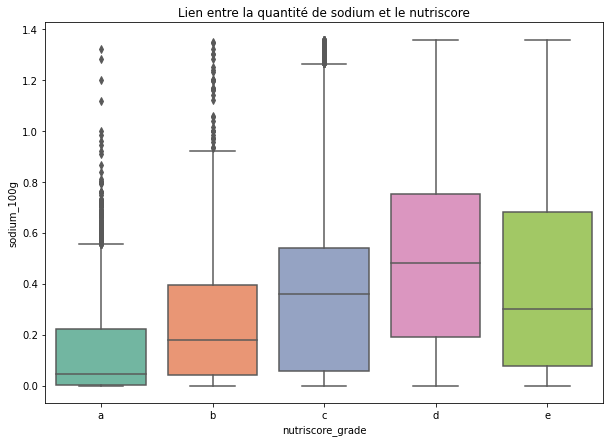

In [73]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="nutriscore_grade", y="sodium_100g", data=df)
plt.title("Lien entre la quantité de sodium et le nutriscore")
plt.show()

In [74]:
pg.welch_anova(data=df, dv="sodium_100g", between="nutriscore_grade")

,Source,ddof1,ddof2,F,p-unc,np2
0,nutriscore_grade,4,184104.136134,37390.096283,0.0,0.200662


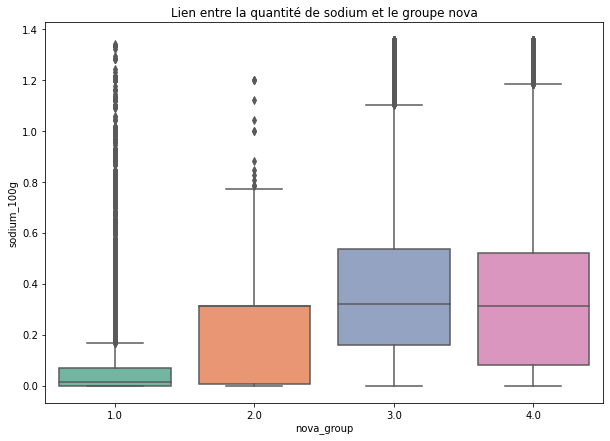

In [75]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="nova_group", y="sodium_100g", data=df)
plt.title("Lien entre la quantité de sodium et le groupe nova")
plt.show()

In [76]:
pg.welch_anova(data=df, dv="sodium_100g", between="nova_group")

,Source,ddof1,ddof2,F,p-unc,np2
0,nova_group,3,9803.866686,38063.942194,0.0,0.102538


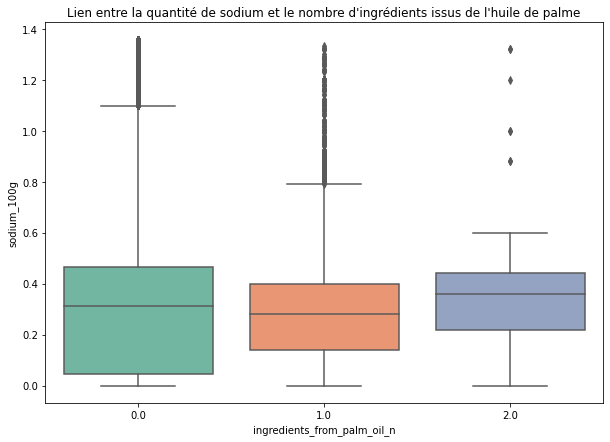

In [77]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="ingredients_from_palm_oil_n", y="sodium_100g", data=df)
plt.title("Lien entre la quantité de sodium et le nombre d'ingrédients issus de l'huile de palme")
plt.show()

In [78]:
pg.welch_anova(data=df, dv="sodium_100g", between="ingredients_from_palm_oil_n")

,Source,ddof1,ddof2,F,p-unc,np2
0,ingredients_from_palm_oil_n,2,284.062561,6.799986,0.001304,0.000302


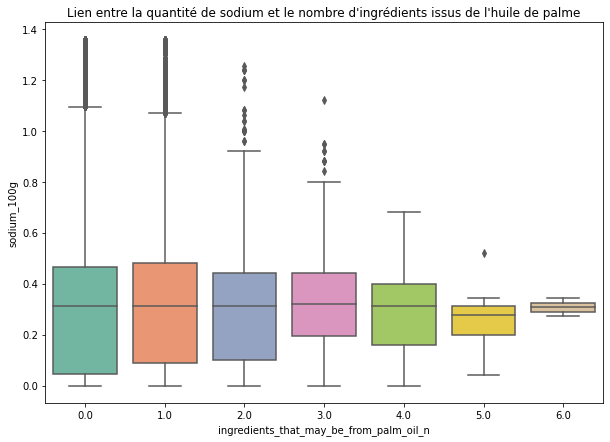

In [79]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="ingredients_that_may_be_from_palm_oil_n", y="sodium_100g", data=df)
plt.title("Lien entre la quantité de sodium et le nombre d'ingrédients issus de l'huile de palme")
plt.show()

In [80]:
pg.welch_anova(data=df, dv="sodium_100g", between="ingredients_that_may_be_from_palm_oil_n")

,Source,ddof1,ddof2,F,p-unc,np2
0,ingredients_that_may_be_from_palm_oil_n,6,14.940299,17.892874,0.000005,0.000518


### Analyse entre la quantité d'énergie et les différentes variables qualitatives

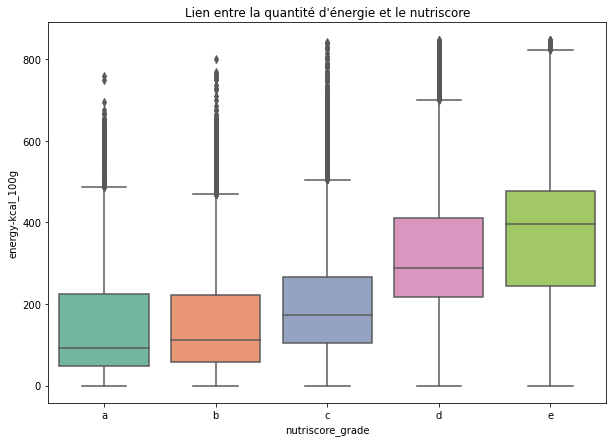

In [81]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="nutriscore_grade", y="energy-kcal_100g", data=df)
plt.title("Lien entre la quantité d'énergie et le nutriscore")
plt.show()

In [82]:
pg.welch_anova(data=df, dv="energy-kcal_100g", between="nutriscore_grade")

,Source,ddof1,ddof2,F,p-unc,np2
0,nutriscore_grade,4,186467.079346,33577.115521,0.0,0.245454


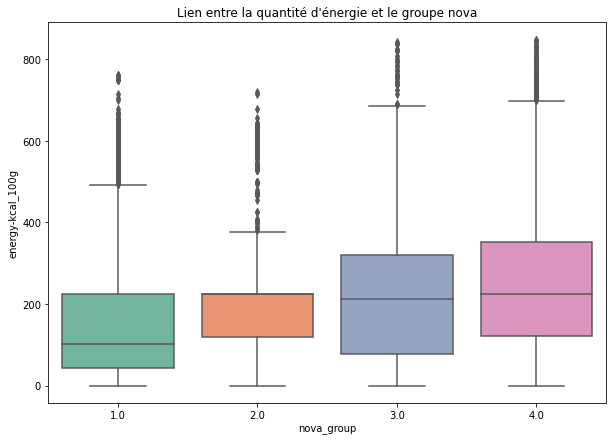

In [84]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="nova_group", y="energy-kcal_100g", data=df)
plt.title("Lien entre la quantité d'énergie et le groupe nova")
plt.show()

In [85]:
pg.welch_anova(data=df, dv="energy-kcal_100g", between="nova_group")

,Source,ddof1,ddof2,F,p-unc,np2
0,nova_group,3,9530.115803,4105.437563,0.0,0.030414


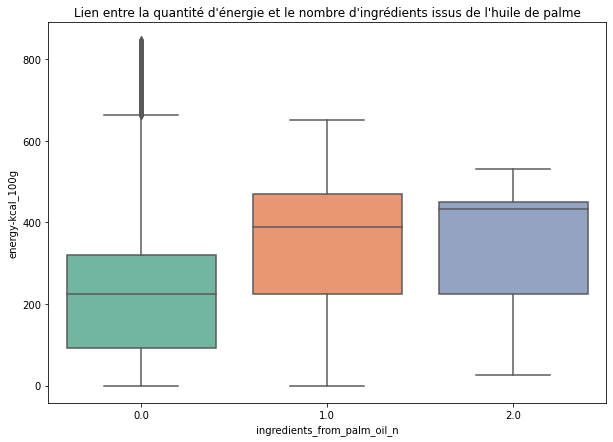

In [86]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="ingredients_from_palm_oil_n", y="energy-kcal_100g", data=df)
plt.title("Lien entre la quantité d'énergie et le nombre d'ingrédients issus de l'huile de palme")
plt.show()

In [87]:
pg.welch_anova(data=df, dv="energy-kcal_100g", between="ingredients_from_palm_oil_n")

,Source,ddof1,ddof2,F,p-unc,np2
0,ingredients_from_palm_oil_n,2,283.962747,2767.238024,6.095724e-187,0.012317


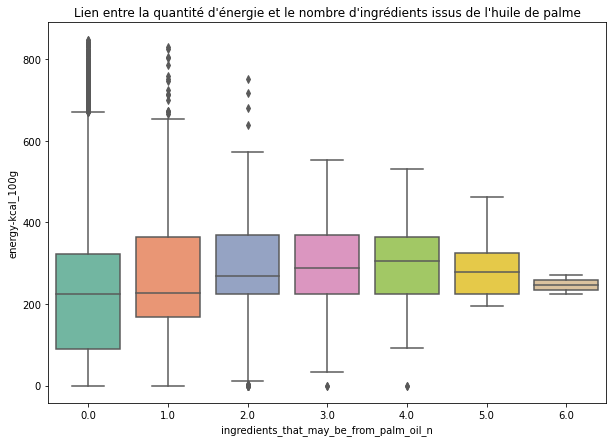

In [88]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="ingredients_that_may_be_from_palm_oil_n", y="energy-kcal_100g", data=df)
plt.title("Lien entre la quantité d'énergie et le nombre d'ingrédients issus de l'huile de palme")
plt.show()

In [89]:
pg.welch_anova(data=df, dv="energy-kcal_100g", between="ingredients_that_may_be_from_palm_oil_n")

,Source,ddof1,ddof2,F,p-unc,np2
0,ingredients_that_may_be_from_palm_oil_n,6,14.938035,461.369873,4.390287e-16,0.005294


## Analyses bivariées entre les variables qualitatives

In [90]:
pg.chi2_independence(data=df, x="nutriscore_grade", y="nova_group")

(nova_group                1.0         2.0           3.0           4.0
 nutriscore_grade                                                     
 a                 6853.737005  101.850322  13228.797743  35582.614930
 b                 5087.671038   75.605605   9820.010762  26413.712594
 c                 7955.899816  118.229071  15356.146501  41304.724613
 d                 9406.482739  139.785536  18156.001249  48835.730477
 e                 4544.209403   67.529465   8771.043745  23592.217387,
 nova_group          1.0  2.0    3.0    4.0
 nutriscore_grade                          
 a                 22448   75  16353  16891
 b                  5083   81  11457  24776
 c                  3799  254  16255  44427
 d                  1411   89  16771  58267
 e                  1107    4   4496  31368,
                  test    lambda           chi2   dof  pval    cramer  power
 0             pearson  1.000000   65084.267932  12.0   0.0  0.132979    1.0
 1        cressie-read  0.666667   6173

In [91]:
pg.chi2_independence(data=df, y="ingredients_from_palm_oil_n", x="ingredients_that_may_be_from_palm_oil_n")

(ingredients_from_palm_oil_n                        0.0          1.0  \
 ingredients_that_may_be_from_palm_oil_n                               
 0.0                                      376490.280477  6557.737305   
 1.0                                       22091.229246   384.786768   
 2.0                                        3062.821882    53.348472   
 3.0                                         589.571103    10.269196   
 4.0                                         145.427539     2.533068   
 5.0                                          16.704515     0.290961   
 6.0                                           1.965237     0.034231   
 
 ingredients_from_palm_oil_n                     2.0  
 ingredients_that_may_be_from_palm_oil_n              
 0.0                                      101.982218  
 1.0                                        5.983986  
 2.0                                        0.829645  
 3.0                                        0.159701  
 4.0                

# Réduction de dimensions